In [1]:
from src.catching import attempt_catch
from src.pokemon import PokemonFactory, Pokemon, StatusEffect
from typing import Tuple, List

import matplotlib.pyplot as plt
import matplotlib.cm as cm  

import seaborn as sns
import pandas as pd
import numpy as np
import json

In [2]:
factory = PokemonFactory()
ball_types = [ "pokeball", "ultraball", "fastball", "heavyball" ]

In [3]:
pokes = factory.create_all(level=100)

In [4]:
avg_per_poke = {}
for ball in ball_types:
    avg_per_poke[ball] = {}
    for poke in pokes:
        count = 0
        tot = 0
        for i in range(1, 1000):
            count += 1
            was_captured, capture_rate = attempt_catch(poke, ball)
            tot += was_captured
        avg_per_poke[ball][poke.name] = tot/count

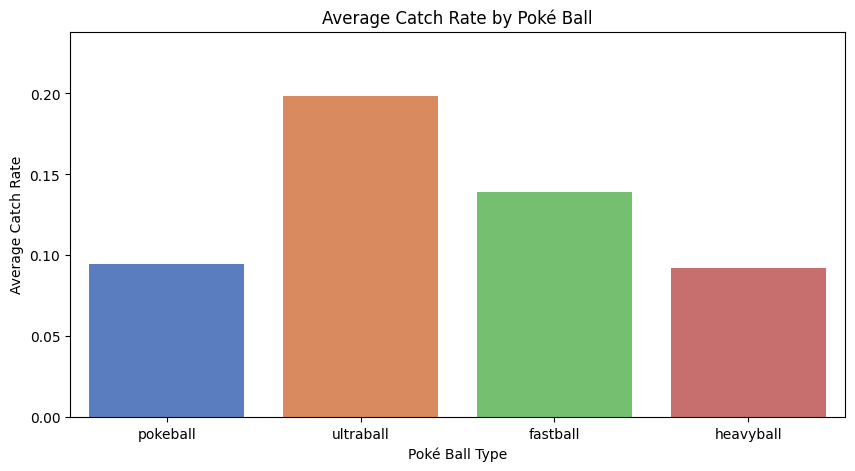

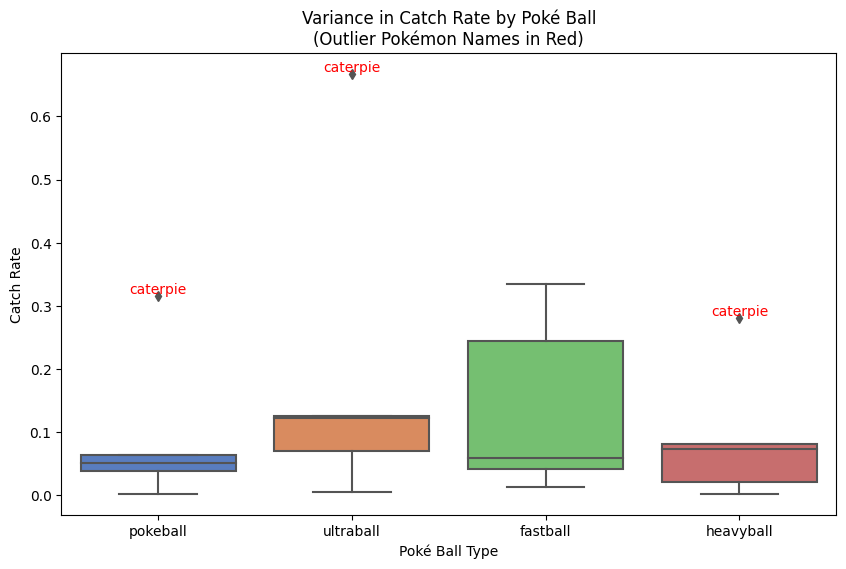

In [5]:
poke_names = []
catch_rates = []
ball_labels = []

for ball, pokes in avg_per_poke.items():
    for poke, rate in pokes.items():
        poke_names.append(poke)
        catch_rates.append(rate)
        ball_labels.append(ball)

# Create a DataFrame for Seaborn
df = pd.DataFrame({'Poké Ball': ball_labels, 'Catch Rate': catch_rates, 'Pokémon': poke_names})

avg_rates = {ball: np.mean(list(avg_per_poke[ball].values())) for ball in ball_types}

plt.figure(figsize=(10, 5))
sns.barplot(x=list(avg_rates.keys()), y=list(avg_rates.values()), palette="muted")
plt.xlabel("Poké Ball Type")
plt.ylabel("Average Catch Rate")
plt.title("Average Catch Rate by Poké Ball")
plt.ylim(0, max(avg_rates.values()) * 1.2)  # Add some padding
plt.show()

plt.figure(figsize=(10, 6))
ax = sns.boxplot(x="Poké Ball", y="Catch Rate", data=df, palette="muted")

# Identify Outliers
for ball in ball_types:
    ball_data = df[df['Poké Ball'] == ball]['Catch Rate']
    q1 = np.percentile(ball_data, 25)
    q3 = np.percentile(ball_data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    outliers = df[(df['Poké Ball'] == ball) & ((df['Catch Rate'] < lower_bound) | (df['Catch Rate'] > upper_bound))]

    for _, row in outliers.iterrows():
        plt.text(ball_types.index(ball), row['Catch Rate'], row['Pokémon'], 
                 horizontalalignment='center', verticalalignment='bottom', fontsize=10, color='red')

plt.xlabel("Poké Ball Type")
plt.ylabel("Catch Rate")
plt.title("Variance in Catch Rate by Poké Ball\n(Outlier Pokémon Names in Red)")
plt.show()

### ej_1b

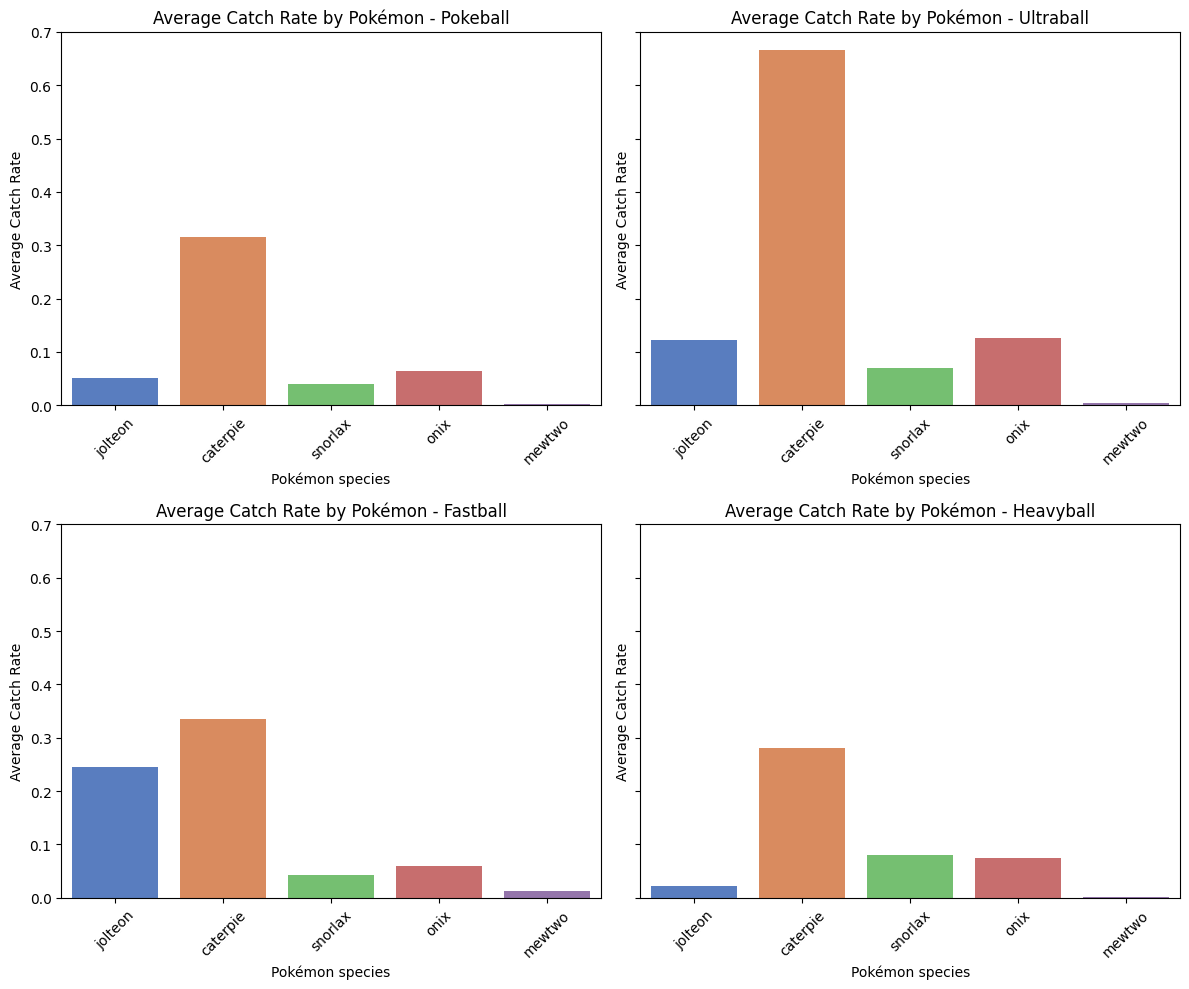

In [6]:
# sharey=True makes them all have the same scale
# the axes are each of the subfigures
_, axes = plt.subplots(2, 2, figsize=(12, 10), sharey=True)

for ax, (ball, pokemon) in zip(axes.flat, avg_per_poke.items()):
    sns.barplot(x=list(pokemon.keys()), y=list(pokemon.values()), palette="muted", ax=ax)    
    ax.set_xlabel("Pokémon species")
    ax.set_ylabel("Average Catch Rate")
    ax.set_title(f"Average Catch Rate by Pokémon - {ball.capitalize()}")
    ax.set_xticklabels(pokemon.keys(), rotation=45, ha="center")
plt.tight_layout()
plt.show()

## Ej_2

In [7]:
# Returns a Tuple containing the pokemon and pokeball specified in the single_catch.json file
def get_single_catch_data_from_config() -> Tuple[Pokemon, str]:
    factory = PokemonFactory("pokemon.json")

    with open("configs/single_catch.json", "r") as f:
        config = json.load(f)
    ball = config["pokeball"]
    pokemon = factory.create(config["pokemon"], config["level"], StatusEffect.from_string(config["status"]), config["hp"])    
    return (pokemon, ball)

# Returns a Tuple containing the list of pokemon and pokeball specified in the multiple_catch.json file
def get_multiple_catch_data_from_config(level=None) -> Tuple[List[Pokemon], str]:
    factory = PokemonFactory("pokemon.json")

    with open("configs/multiple_catch.json", "r") as f:
        config = json.load(f)
    ball = config["pokeball"]
    pokemon_list = factory.create_many(
        config["pokemon"], 
        level if level else config["level"], 
        StatusEffect.from_string(config["status"]), 
        config["hp"]
    )
    return (pokemon_list, ball)

### Ej_2a

In [8]:
poke, ball = get_single_catch_data_from_config()
effect_vs_catch_rate = {}
for effect in sorted(list(StatusEffect), key=lambda x: x.modifier):
    poke.set_status_effect(effect)
    effect_vs_catch_rate[effect.status_name.lower().capitalize()] = attempt_catch(poke, ball)[1]

print(effect_vs_catch_rate)

{'None': 0.2344, 'Poison': 0.3516, 'Burn': 0.3516, 'Paralysis': 0.3516, 'Sleep': 0.4688, 'Freeze': 0.4688}


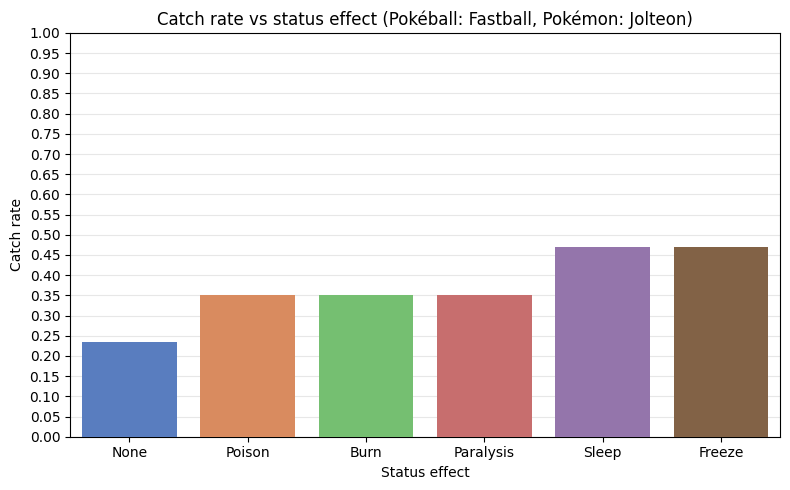

In [9]:
plt.figure(figsize=(8,5))
sns.barplot(x=list(effect_vs_catch_rate.keys()), y=list(effect_vs_catch_rate.values()), palette="muted", zorder=3)
plt.xlabel("Status effect")
plt.ylabel("Catch rate")
plt.title(f"Catch rate vs status effect (Pokéball: {ball.capitalize()}, Pokémon: {poke.name.capitalize()})")

yticks = np.arange(0, 1.05, 0.05)
plt.yticks(yticks)

plt.grid(True, axis="y", alpha=0.3, zorder=1)
plt.tight_layout()
plt.show()


### Ej_2b

In [25]:
hp_perc_vs_catch_rate = {}
hp_perc_vs_catch_rate_with_noise = {}

pokes, ball = get_multiple_catch_data_from_config()

for poke in pokes:
    hp_perc_vs_catch_rate[poke.name] = {}
    hp_perc_vs_catch_rate_with_noise[poke.name] = {}

    hp_perc = round((poke.current_hp* 100)/poke.max_hp)
    while poke.current_hp > 0.01:
        hp_perc_vs_catch_rate[poke.name][hp_perc] = attempt_catch(poke, ball)[1]
        hp_perc_vs_catch_rate_with_noise[poke.name][hp_perc] = attempt_catch(poke, ball, 0.15)[1]
        hp_perc -= 1
        poke.damage(0.01)


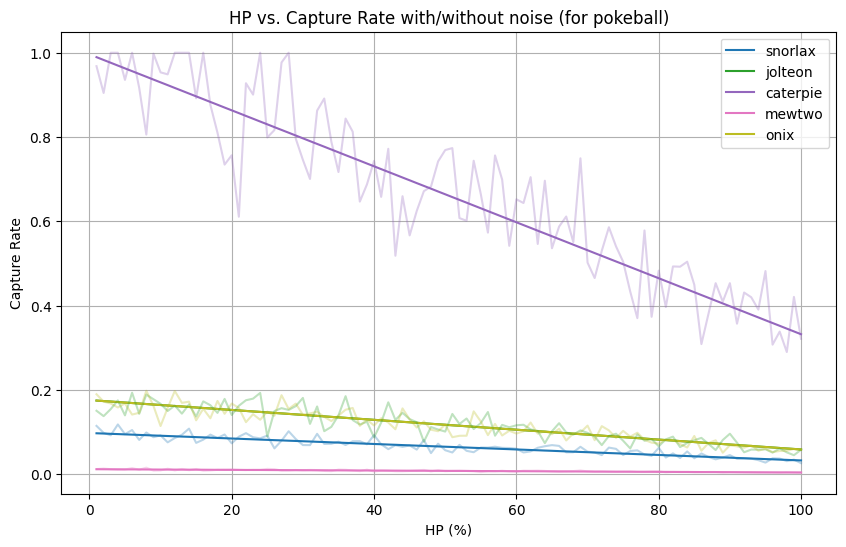

In [26]:
plt.figure(figsize=(10, 6))

colors = plt.get_cmap("tab10")

for i, (poke, rates) in enumerate(hp_perc_vs_catch_rate.items()):
    hp_values = list(rates.keys())
    capture_probs = list(rates.values())
    
    plt.plot(hp_values, capture_probs, linestyle="-", color=colors(i / len(hp_perc_vs_catch_rate)), label=f"{poke}")

for i, (poke, rates) in enumerate(hp_perc_vs_catch_rate_with_noise.items()):
    hp_values = list(rates.keys())
    capture_probs = list(rates.values())
    
    plt.plot(hp_values, capture_probs, linestyle="-", color=colors(i / len(hp_perc_vs_catch_rate_with_noise)), alpha=0.3)

plt.xlabel("HP (%)")
plt.ylabel("Capture Rate")
plt.title(f"HP vs. Capture Rate with/without noise (for {ball})")
plt.legend()
plt.grid()
plt.show()

**Nota**: Se aclara que los gráficos de líneas rectas son sin ruido y los gráficos dispersos que la acompañan son para el caso de con ruido

### Ej_2c

> Para este asumo que hay que mencionar las propiedades que se trataron en los ejs 2.a y 2.b, pues en el enunciado no se pide nada respecto a pokeball 
> (y lo hace recién en el 2.d), también se podría mencionar como cada pokémon parece tener una probabilidad intríncica diferente (ej mewtwo vs caterpie) > y poner gráficos para comparar dos pokés en condiciones ideales y con una pokéball o ultraball que no se ve afectada por sus propiedades inmutables
> (como se vio en el Ej_1b) ~ Berni 

In [12]:
poke, ball = get_single_catch_data_from_config()
poke.damage(0.9)
_, low_hp_catch_rate = attempt_catch(poke, ball)
sleep_catch_rate = effect_vs_catch_rate['Sleep']

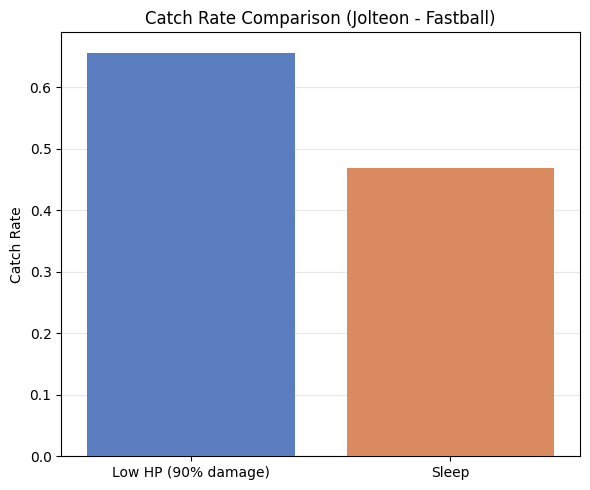

In [13]:
categories = ["Low HP (90% damage)", "Sleep"]
values = [low_hp_catch_rate, sleep_catch_rate]

# Create figure
plt.figure(figsize=(6, 5))
sns.barplot(x=categories, y=values, palette="muted", zorder=3)

# Labels and title
plt.ylabel("Catch Rate")
plt.title(f"Catch Rate Comparison ({poke.name.capitalize()} - {ball.capitalize()})")

# Grid settings
plt.grid(True, axis="y", alpha=0.3, zorder=0)

# Show plot
plt.tight_layout()
plt.show()

### Ej_2d

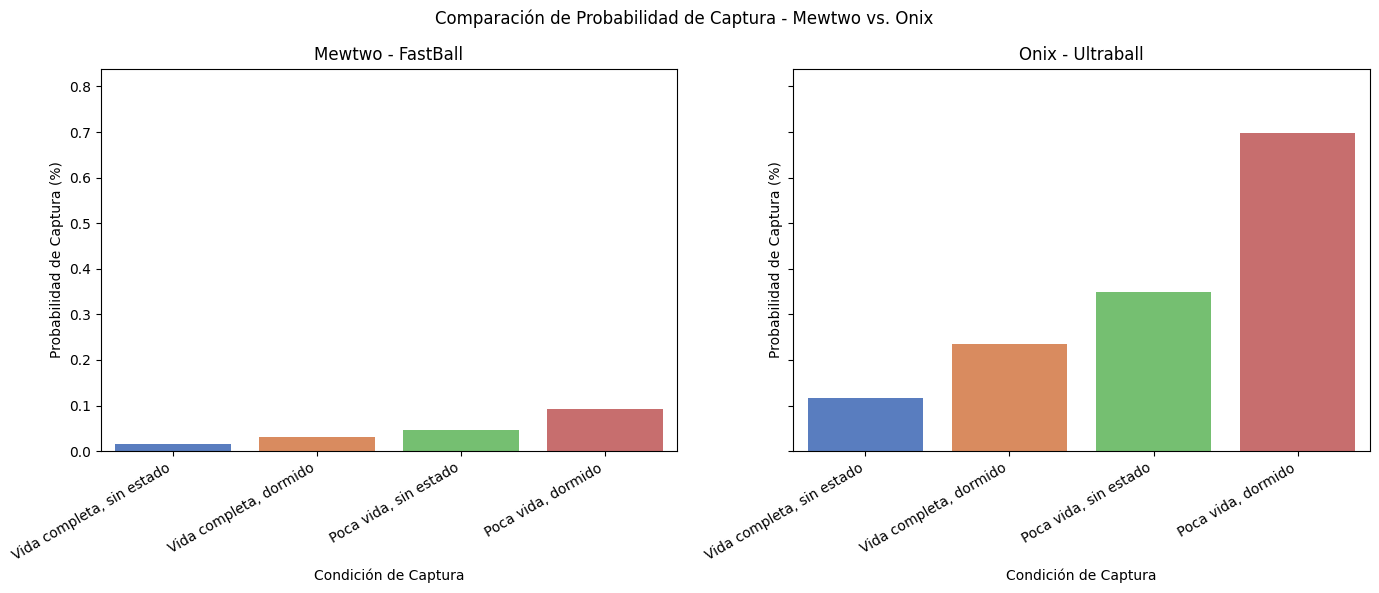

In [14]:
# Definir los escenarios de prueba
scenarios = [
    ("Mewtwo - FastBall", "mewtwo", "fastball"),
    ("Onix - Ultraball", "onix", "ultraball"),
]

status_conditions = [
    ("Vida completa, sin estado", 1.0, StatusEffect.NONE),
    ("Vida completa, dormido", 1.0, StatusEffect.SLEEP),
    ("Poca vida, sin estado", 0.01, StatusEffect.NONE),
    ("Poca vida, dormido", 0.01, StatusEffect.SLEEP),
]

# Diccionario para almacenar los resultados
capture_results = {scenario[0]: {} for scenario in scenarios}

# Simular cada escenario
for scenario_label, pokemon_name, ball in scenarios:
    for label, hp_percentage, status in status_conditions:
        pokemon = factory.create(
            name = pokemon_name,
            level = 100,
            status = status,
            hp_percentage = hp_percentage
        )

        was_captured, capture_rate = attempt_catch(pokemon,ball)
        capture_results[scenario_label][label] = capture_rate

# Crear figura con 2 subgráficos 
fig, axes = plt.subplots(1, 2, figsize = (14,6), sharey = True)

# Graficar cada escenario en su respectiva ventana
for ax, (scenario_label, scenario_results) in zip(axes, capture_results.items()):
    # Ordenamos los resultados de menor a mayor
    sorted_results = dict(sorted(scenario_results.items(), key=lambda x: x[1]))
    
    sns.barplot(x=list(sorted_results.keys()), y=list(sorted_results.values()), palette="muted", ax=ax)
    ax.set_xlabel("Condición de Captura")
    ax.set_ylabel("Probabilidad de Captura (%)")
    ax.set_title(scenario_label)
    ax.set_xticklabels(sorted_results.keys(), rotation=30, ha="right")

plt.suptitle("Comparación de Probabilidad de Captura - Mewtwo vs. Onix")
plt.ylim(0, max(max(capture_results[s].values()) for s in capture_results) * 1.2)
plt.tight_layout()
plt.show()

### Ej_2e

In [15]:
# level_vs_catch_rate = {}

# pokes, ball = get_multiple_catch_data_from_config(level=1)

# for poke in pokes:
#     level_vs_catch_rate[poke.name] = []
#     while poke.level_up():
#         catch_rate = attempt_catch(poke, ball)[1] * 10000
#         print(f'lvl: {poke.level} - hp: {poke.current_hp}/{poke.max_hp} - catch rate: {catch_rate}')
#         level_vs_catch_rate[poke.name].append(catch_rate)
#     break

# level_vs_catch_rate

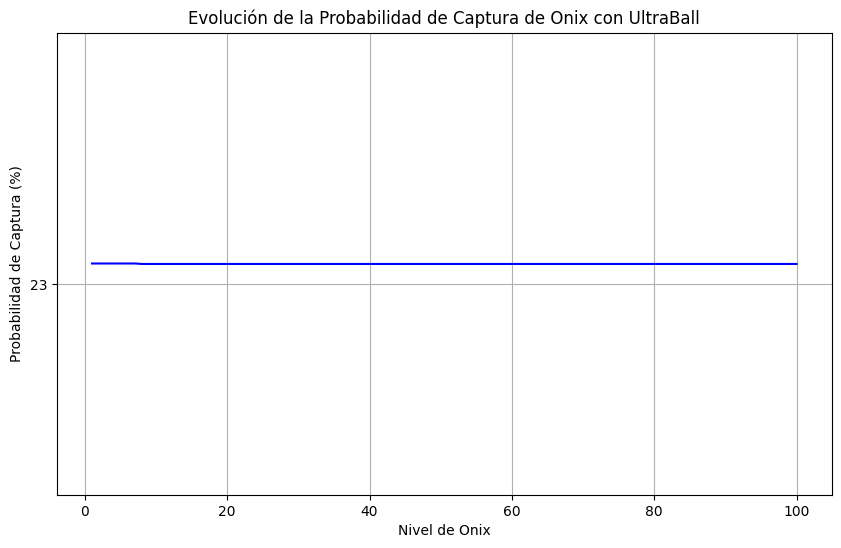

In [17]:
# Definir niveles a probar
level_conditions = [
    ("Nivel 1", 1),
    ("Nivel 50", 50),
    ("Nivel 100", 100),
]

# Diccionario para almacenar los resultados
level_results = {}

# Simular cada escenario
for label, level in level_conditions:
    pokemon = factory.create(
        name="onix",
        level=level,
        status=StatusEffect.SLEEP,
        hp_percentage=0.01
    )

    was_captured, capture_rate = attempt_catch(pokemon, "ultraball")
    level_results[label] = capture_rate * 100

# Diccionario para evolución de captura según nivel
level_vs_catch_rate = {}

# Crear Onix con condiciones óptimas en nivel 1
ball = "ultraball"
onix = factory.create(
    name="onix",
    level=1,
    status=StatusEffect.SLEEP,
    hp_percentage=1
)

# Simular la evolución del nivel hasta 100
for i in range(1, 101):
    capture_rate = attempt_catch(onix, ball)[1] * 100
    level_vs_catch_rate[onix.level] = capture_rate
    onix.level_up()

# Graficar los resultados en un gráfico de líneas con mejor escala
plt.figure(figsize=(10, 6))
sns.lineplot(x=list(level_vs_catch_rate.keys()), y=list(level_vs_catch_rate.values()), color="b")

plt.xlabel("Nivel de Onix")
plt.ylabel("Probabilidad de Captura (%)")
plt.title("Evolución de la Probabilidad de Captura de Onix con UltraBall")

plt.ylim(min(level_vs_catch_rate.values()) - 5, max(level_vs_catch_rate.values()) + 5)
plt.yticks(range(int(min(level_vs_catch_rate.values())), int(max(level_vs_catch_rate.values())) + 5, 5))
plt.grid(True)
plt.show()